# plot

> Collection of plotting functions.

In [ ]:
# | default_exp plot

In [ ]:
# | hide

from fastcore.docments import docments
from fastcore.test import *
from nbdev.showdoc import *

In [ ]:
# | export

import os
import pickle
from typing import Any, Tuple, Union

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scanpy as sc
import seaborn as sns
from matplotlib.patches import Circle, Rectangle
from plotly.subplots import make_subplots
from samap.mapping import SAMAP

from comandos import dotplot_util as du
from comandos import util

In [ ]:
# | hide
if "EXAMPLE_DATA_PATH" not in os.environ.keys():
    os.environ[
        "EXAMPLE_DATA_PATH"
    ] = "/Users/npapadop/Documents/repos/comandos/example_data/"

## See the big picture

These functions are intended to help you find your way around the data. I use them a lot when
generating reports for collaborators, to set the stage for the more detailed analyses. In
particular, I want to highlight which clusters we are comparing and where they are in the context of
both species as well as the comparison.

In [ ]:
# | export


def highlighted_dimplot(
    adata: ad.AnnData,
    species: str,
    clustering: str,
    cluster: str,
    embedding: str = "X_umap",
    highlight: str = "red",
    figsize: tuple = (10, 10),
    save: Union[str, None] = None,
):
    """
    Plot a low-dimensional embedding and highlight a chosen cluster with a superimposed circle.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object to plot.
    species : str
        Species name. Will be used in the title, and removed from the cluster names if present.
    clustering : str
        Clustering to plot. Must be present in `adata.obs`.
    cluster : str
        Cluster to highlight.
    embedding : str, optional
        Embedding to plot (default: "X_umap").
    highlight : str, optional
        Color of the circle (default: "red").
    figsize : tuple, optional
        Figure size (default: (10, 10)).
    save : str, optional
        Path to save the figure (default: None).

    Returns
    -------
    None
    """
    cluster_cells = adata.obs[clustering] == cluster.replace(species + "_", "")
    coords = adata.obsm[embedding][cluster_cells]
    cx, cy = util.find_center(coords)
    radius = np.mean(np.std(coords, axis=0))
    if radius < 0.5:
        radius = 0.5
    elif radius > 2:
        radius = 2
    _fig, ax = plt.subplots(figsize=figsize)
    g = sc.pl.embedding(
        adata,
        basis=embedding,
        color=clustering,
        legend_loc="on data",
        ax=ax,
        show=False,
        title=species,
    )
    g.axes.add_patch(
        Circle((cx, cy), radius, linewidth=3, facecolor="none", edgecolor=highlight)
    )
    g.set_title(species)
    if save is not None:
        plt.savefig(save)

In [ ]:
planarian = sc.read_h5ad(os.environ["EXAMPLE_DATA_PATH"] + "planarian.h5ad")

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


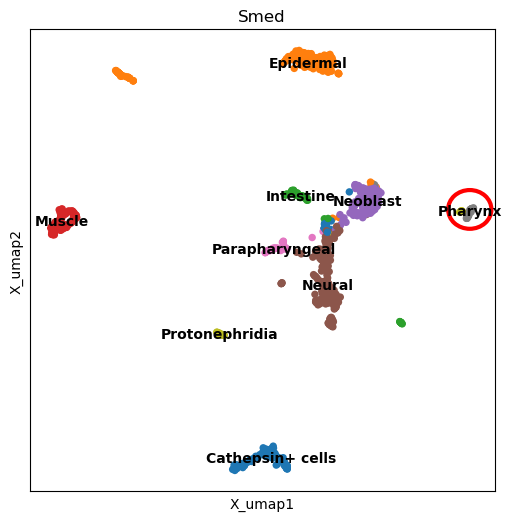

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Pharynx", figsize=(6, 6))

Of course, if a cluster is too spread out, the plot will not work as well, but it will still be
useful to see the general location of the cluster.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


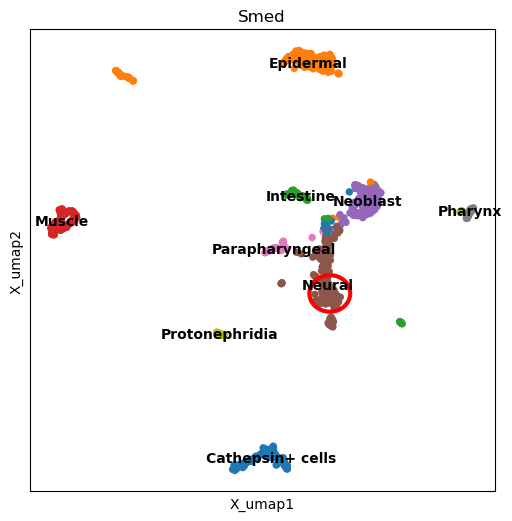

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Neural", figsize=(6, 6))

Another case that might not work so well is if the shape of a cluster is not Gaussian. Still, it
should help us spot the cluster, especially if the color contrasts enough.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


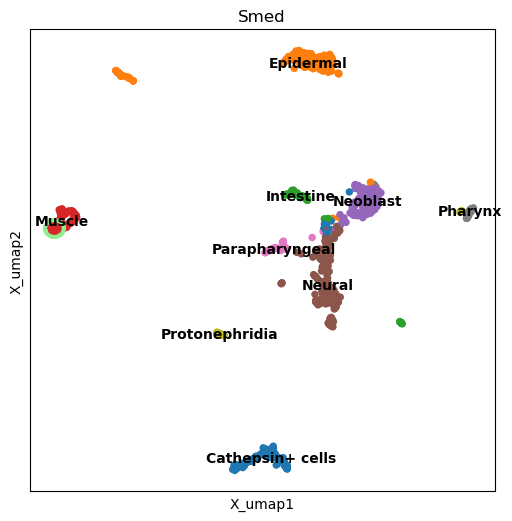

In [ ]:
highlighted_dimplot(
    planarian, "Smed", "tissue", "Muscle", figsize=(6, 6), highlight="lightgreen"
)

In [ ]:
# | export


def highlighted_heatmap(to_plot, celltype_from, celltype_to, figheight=20, save=None):
    """
    Plot a heatmap of pairwise similarities between cell types, with a red box highlighting the
    query cell type.

    Parameters
    ----------
    to_plot : pd.DataFrame
        A dataframe of pairwise similarities between cell types.
    celltype_from : str
        Cell type of the query species to highlight. Must be in `to_plot.columns`.
    celltype_to : str
        Cell type of the target species to highlight. Must be in `to_plot.index`.
    figheight : float, optional
        Height of the resulting plot in inches. Width will be calculated automatically (default:
        20).
    save : str, optional
        Path to result figure; if None, the figure will be plotted but not saved (default: None).

    Returns
    -------
    None
    """
    figwidth = int(to_plot.shape[0] / to_plot.shape[1] * figheight)
    y = np.where(to_plot.columns == celltype_from)[0][0]
    x = np.where(to_plot.index == celltype_to)[0][0]

    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    g = sns.heatmap(to_plot.T, ax=ax, cmap="mako")

    ax = g.axes
    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor="red", lw=3))
    ax.hlines(y + 0.5, 0, x, colors="red", linestyles="dashed")
    ymax = to_plot.shape[1]
    ax.vlines(x + 0.5, y + 1, ymax, colors="red", linestyles="dashed")
    if save is not None:
        plt.savefig(save)

In [ ]:
hysc = pd.read_csv(
    os.environ["EXAMPLE_DATA_PATH"] + "hysc_similarity_table.csv",
    index_col=0,
)

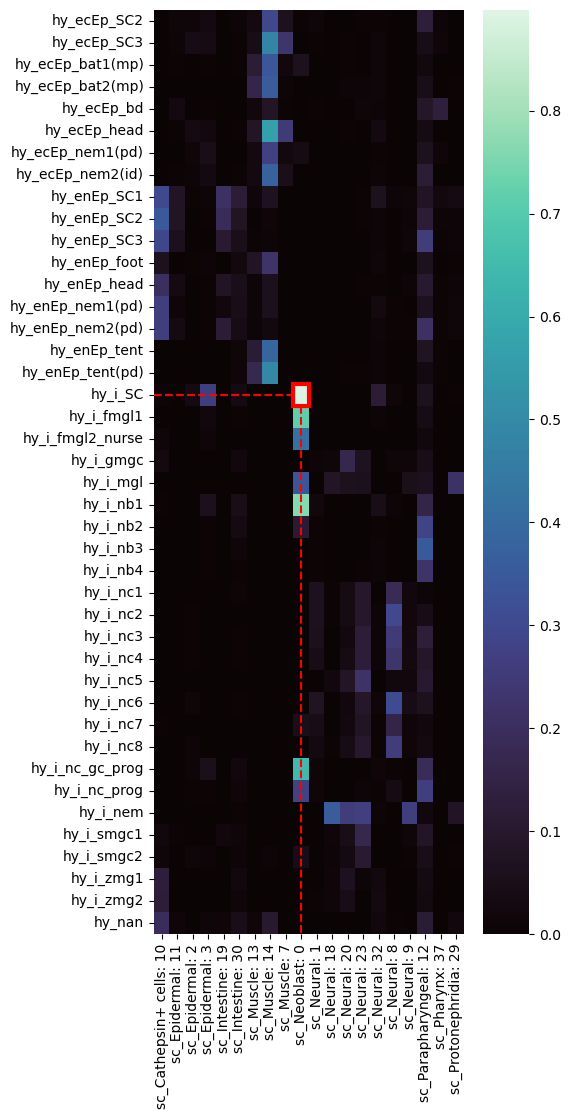

In [ ]:
highlighted_heatmap(
    hysc, celltype_from="hy_i_SC", celltype_to="sc_Neoblast: 0", figheight=12
)

In [ ]:
# | exporti


def _plot_clustermap(
    similarity,
    query_map,
    target_map,
    query_handles,
    target_handles,
    query_lut,
    target_lut,
    query_species,
    target_species,
    query_clustering,
    target_clustering,
    query_coarse,
    target_coarse,
    figsize,
    save,
    **kwargs,
):
    if figsize is None:
        figsize = np.array(similarity.shape) / 3

    sns.clustermap(
        similarity,
        cmap="magma_r",
        figsize=figsize,
        col_cluster=None,
        row_cluster=None,
        dendrogram_ratio=0.1,
        colors_ratio=0.02,
        cbar_pos=(0.04, 0.75, 0.02, 0.15),
        row_colors=target_map.set_index(target_clustering)[target_coarse],
        col_colors=query_map.set_index(query_clustering)[query_coarse],
        linecolor="black",
        linewidths=0.5,
        **kwargs,
    )

    query_legend = plt.legend(
        query_handles,
        query_lut,
        title=f"{query_species}\nmajor cell types",
        bbox_to_anchor=(0.07, 0.7),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )
    plt.gca().add_artist(query_legend)

    plt.legend(
        target_handles,
        target_lut,
        title=f"{target_species}\nmajor cell types",
        bbox_to_anchor=(0.06, 0.5),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )

    if save is not None:
        plt.savefig(save)

In [ ]:
# | exporti


def _plotly_clustermap(
    similarity,
    query_map,
    target_map,
    query_clustering,
    target_clustering,
    query_coarse,
    target_coarse,
    figsize,
    save,
    dpi=300,
):
    query_colors = query_map.set_index(query_clustering)
    query_colors["cc"] = pd.Categorical(query_colors[query_coarse])
    query_colors["code"] = query_colors.cc.cat.codes
    # query_info = query_colors.drop(columns=["code", "cc"]).loc[similarity.columns]
    query_info = query_map.set_index("Cluster").loc[similarity.columns]
    query_colors = query_colors.drop(columns=[query_coarse, "cc"]).loc[
        similarity.columns
    ]

    target_colors = target_map.set_index(target_clustering)
    target_colors["cc"] = pd.Categorical(target_colors[target_coarse])
    target_colors["code"] = target_colors.cc.cat.codes
    target_info = target_colors.drop(columns=["code", "cc"]).loc[similarity.index]
    target_colors = target_colors.drop(columns=[target_coarse, "cc"]).loc[
        similarity.index
    ]

    make_subplots(
        rows=2,
        cols=2,
        column_widths=[0.95, 0.05],
        row_heights=[0.95, 0.05],
        vertical_spacing=0.02,
        shared_xaxes=True,
        shared_yaxes=True,
    )

    data_heatmap = go.Heatmap(
        z=similarity.T, x=similarity.index, y=similarity.columns, colorscale="magma_r"
    )

    query_annot = go.Heatmap(
        z=query_colors.loc[similarity.columns],
        text=query_info,
        hoverinfo="text",
        colorscale="Rainbow",
        showscale=False,
        xaxis="x2",
        yaxis="y",
    )
    target_annot = go.Heatmap(
        z=target_colors.loc[similarity.index].T,
        text=target_info.T,
        hoverinfo="text",
        colorscale="Rainbow",
        showscale=False,
        xaxis="x",
        yaxis="y2",
    )

    data = [data_heatmap, query_annot, target_annot]

    layout = go.Layout(
        xaxis=dict(domain=[0, 0.95]),
        yaxis=dict(domain=[0, 0.95]),
        xaxis2=dict(domain=[0.95, 1], showticklabels=False),
        yaxis2=dict(domain=[0.95, 1], showticklabels=False),
    )
    fig = go.Figure(data=data, layout=layout)

    if figsize is not None:
        fig.update_layout(width=figsize[0] * dpi, height=figsize[1] * dpi)

    if save is not None:
        fig.write_html(save + ".html")
        fig.write_json(save + ".json")

    return fig

In [ ]:
# | export


def annotated_heatmap(
    sm: SAMAP,  # SAMAP object
    similarity: pd.DataFrame,  # Similarity matrix. Contains query species clusters as columns and target species clusters as rows.
    query_species: str,  # Query species ID. Will be used in the title. Should prepend the similarity matrix column names.
    target_species: str,  # Target species ID. Will be used in the title. Should prepend the similarity matrix row names.
    query_clustering: str,  # Query species clustering. Must be present in `sm.sams[query_species].adata.obs`.
    target_clustering: str,  # Target species clustering. Must be present in `sm.sams[target_species].adata.obs`.
    query_coarse: Union[
        str, None
    ] = None,  # Query species coarse clustering. Must be present in `sm.sams[query_species].adata.obs`. If None, will be set to `query_clustering` (default: None).
    target_coarse: Union[
        str, None
    ] = None,  # Target species coarse clustering. Must be present in `sm.sams[target_species].adata.obs`. If None, will be set to `target_clustering` (default: None).
    interactive: bool = False,  # If True, will return a plotly figure. Otherwise, will return a matplotlib figure (default: False).
    figsize: Union[
        Tuple[float, float], None
    ] = None,  # Figure size. If None, will be guessed from the size of the similarity matrix (default: None).
    save: Union[
        str, None
    ] = None,  # If not None, will save the figure to the specified path (default: None).
    **kwargs: Any,  # Additional arguments to pass to `seaborn.heatmap` (matplotlib) or `plotly.graph_objects.Figure` (plotly). Among them: dpi (int), which is only used if `interactive=True` to set the figure size in pixels.
) -> Union[
    None, plotly.graph_objects.Figure
]:  # return None if `interactive=False`, otherwise return a plotly figure.
    "Plot the similarity matrix as an annotated heatmap."
    if query_coarse is None:
        query_coarse = query_clustering
    if target_coarse is None:
        target_coarse = target_clustering

    query_map, query_lut, query_handles = util.map_fine_to_coarse(
        sm, query_species, query_clustering, query_coarse
    )
    target_map, target_lut, target_handles = util.map_fine_to_coarse(
        sm, target_species, target_clustering, target_coarse
    )

    query_map[query_coarse] = query_map[query_coarse].replace(to_replace=query_lut)
    target_map[target_coarse] = target_map[target_coarse].replace(to_replace=target_lut)

    if not interactive:
        return _plot_clustermap(
            similarity,
            query_map,
            target_map,
            query_handles,
            target_handles,
            query_lut,
            target_lut,
            query_species,
            target_species,
            query_clustering,
            target_clustering,
            query_coarse,
            target_coarse,
            figsize,
            save,
            **kwargs,
        )
    else:
        return _plotly_clustermap(
            similarity,
            query_map,
            target_map,
            query_clustering,
            target_clustering,
            query_coarse,
            target_coarse,
            figsize,
            save,
            **kwargs,
        )

Read the requisite files: the SAMap object and the pairwise cluster similarity matrix.

In [ ]:
file = open(os.environ["EXAMPLE_DATA_PATH"] + "hypl.pkl", "rb")
sm = pickle.load(file)

hypl = pd.read_csv(
    os.environ["EXAMPLE_DATA_PATH"] + "hypl_similarity_table.csv",
    index_col=0,
)

First improve the coarse level assignments for the data we have here:

In [ ]:
sm.sams["hy"].adata.obs["coarse"] = (
    sm.sams["hy"].adata.obs["Cluster"].str.split("_").str[0]
)
sm.sams["pl"].adata.obs["coarse"] = (
    sm.sams["pl"].adata.obs["tissue_smedwi"].str.split("_").str[0]
)

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


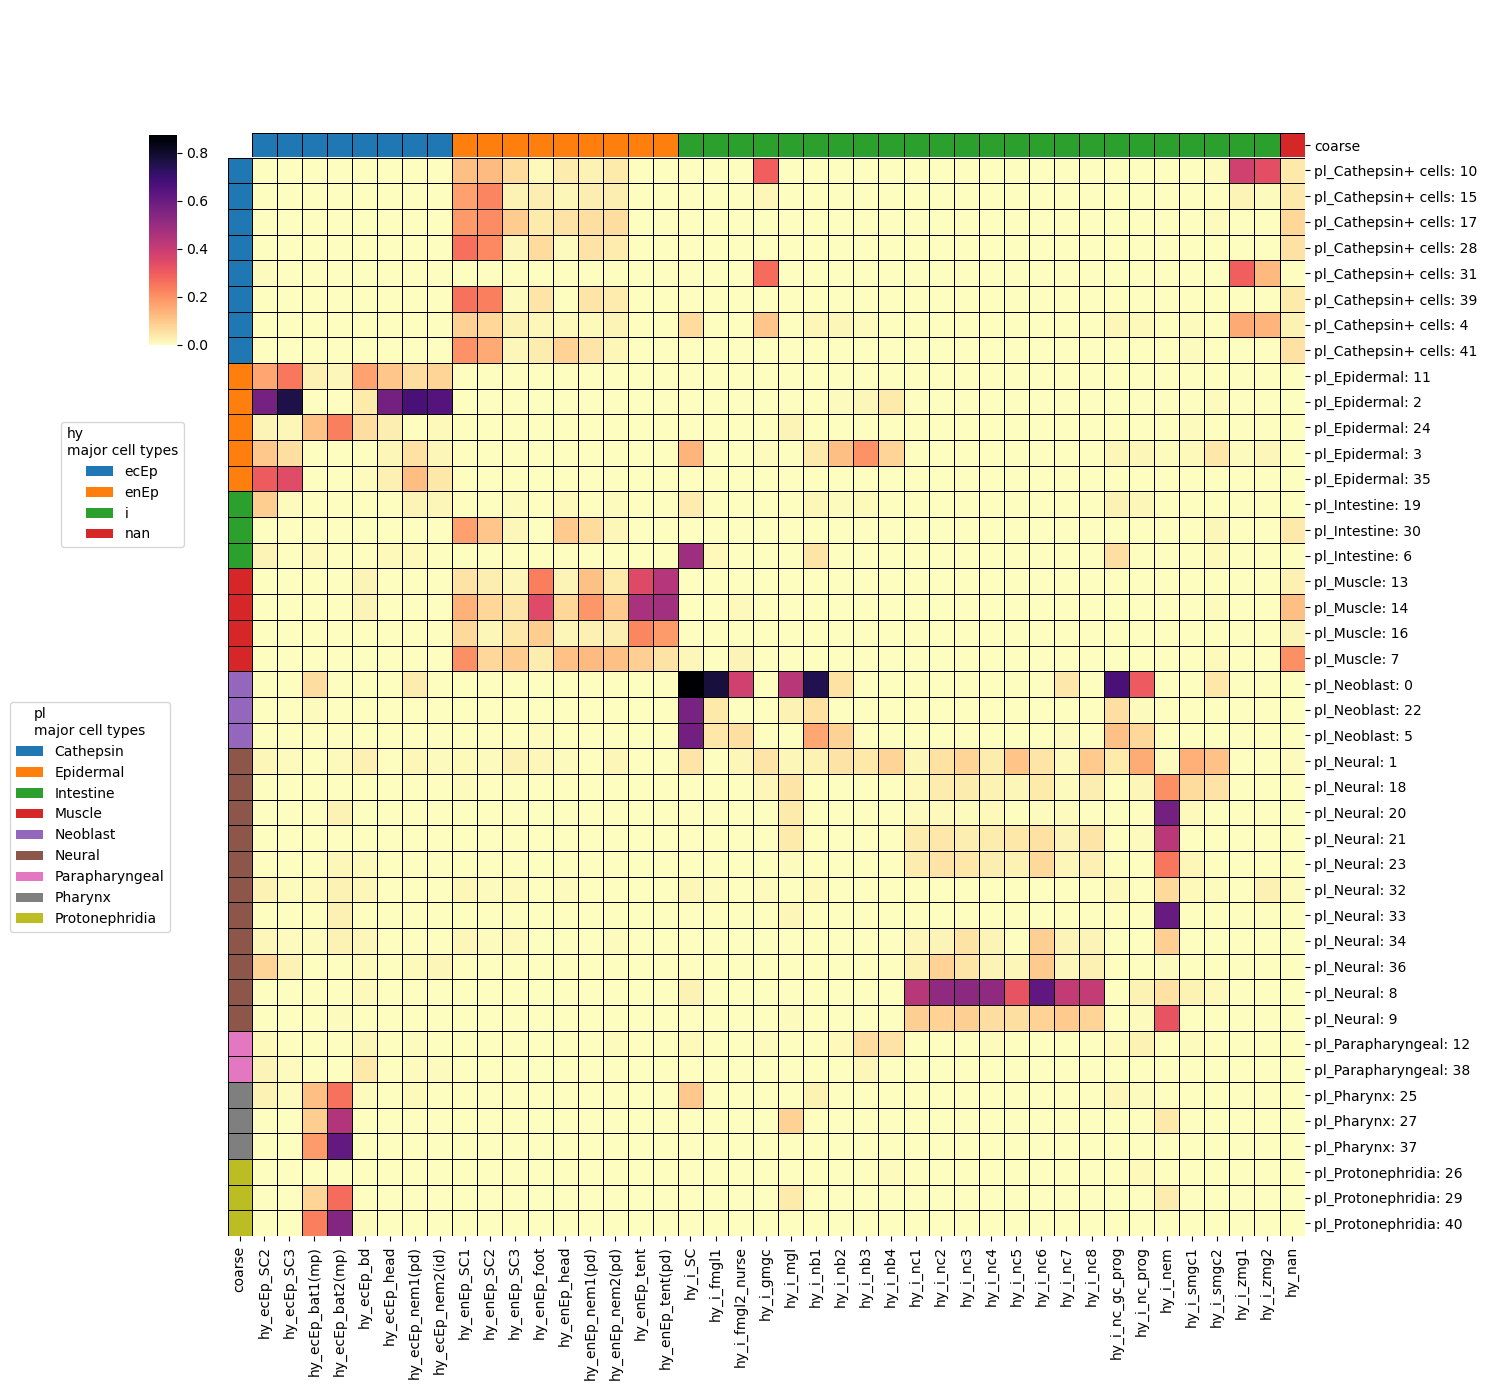

In [ ]:
annotated_heatmap(
    sm,
    hypl,
    "hy",
    "pl",
    query_clustering="Cluster",
    target_clustering="cluster",
    query_coarse="coarse",
    target_coarse="coarse",
    interactive=False,
    save="hypl.pdf",
)

This sort of plot does a much better job of showing the relationships between clusters than the
Sankey diagram. Clear patches of similarity emerge that would be otherwise invisible. This is a
result of the hierarchical relationship between cell types (see Arendt/Musser/Wagner in
[2016](https://www.nature.com/articles/nrg.2016.127) and
[2019](https://www.sciencedirect.com/science/article/pii/S0959438819300194)). By combining maps like
this with the per-species cell type family trees we can start to get a better idea of how cell types
may have evolved over time.

In [ ]:
assert os.path.exists("hypl.pdf")

We can make the same plot in interactive form. Unfortunately, the interactive version is a bit more
finicky with color usage, so for now I'll let `plotly` choose the colors, but any `plotly` wizards
out there are welcome to improve this. Right now hovering over a point will show the cluster names
and SAMap score; hovering over the colored bars at the margins should show the coarse cluster.

In [ ]:
plotly_overview = annotated_heatmap(
    sm,
    hypl,
    "hy",
    "pl",
    query_clustering="Cluster",
    target_clustering="cluster",
    query_coarse="coarse",
    target_coarse="coarse",
    figsize=(10, 10),
    interactive=True,
    dpi=100,
    save="hypl",
)

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
assert os.path.exists("hypl.json")
assert os.path.exists("hypl.html")

You can visualize the plot in a notebook with:

```python
# not run
plotly_overview.show()
```

## Pairwise comparisons

When comparing two clusters, it is most informative to have a look at the genes they are expressing.
If the clusters are in the same species we can use a simple dotplot that combines the two clusters'
marker genes; things are not so simple when comparing between species. By plotting two dotplots side
by side, and connecting homologous genes across the dotplots, we can get a better sense of how the 
clusters are connected.

A lot of the heavy lifting for this idea was already done by the `scanpy` team, who write excellent,
well-documented code. I've adapted their code to produce the paired dotplots, fiddled with it to
make sure dot size and color are consistent across plots, and added the homology lines. The latter
part is rather tricky, and I would be thankful to anyone who can improve it; currently it involves
a lot of heuristics to translate the coordinates from one side of the plot to the other.

In [ ]:
# | export


def paired_dotplot(
    query: ad.AnnData,  # query species AnnData object
    target: ad.AnnData,  # target species AnnData object
    connections: np.array,  # array of connected genes. Each row has at least two columns containing the query species gene and corresponding target species gene, and optionally their connection strength. Genes are allowed to be repeated on both sides.
    query_clustering: str,  # `.obs` column in the query AnnData object containing the query species clustering.
    target_clustering: str,  # `.obs` column in the target AnnData object containing the target species clustering.
    query_species: str,  # query species name. Will only be used in the title, so does not have to conform with the query species ID in the similarity matrix/SAMap object.
    target_species: str,  # target species name. Will only be used in the title, so does not have to conform with the target species ID in the similarity matrix/SAMap object.
    query_cluster: Union[
        str, None
    ] = None,  # the cell type/cluster of the query species that is being compared (default: None).
    target_cluster: Union[
        str, None
    ] = None,  # the cell type/cluster of the target species that is being compared (default: None).
    pad: bool = True,  # whether to pad the gene names with spaces to make them all of a similar length (default: True).
    x_offset: float = 1,  # Number of inches to add to the horizontal size of the canvas (default: 1).
    y_offset: float = 0,  # Number of inches to add to the vertical size of the canvas (default: 0).
    grid_offset: float = 30,  # Grid segments to add between the two dotplots. Might be useful if the gene names are not legible/lines overlap (default: 30).
    query_gene_names: Union[
        str, None
    ] = None,  # `.var` column that holds unique gene names for the query species (default: None).
    target_gene_names: Union[
        str, None
    ] = None,  # `.var` column that holds unique gene names for the target species (default: None).
    output: str = "./paired_dotplot.png",  # path to save the plot to (default: "./paired_dotplot.png").
    center: bool = True,  # whether to center the dotplot (default: True).
    title: Union[str, None] = None,  # overall title of the plot (default: None).
    title_font_size: float = 16,  # font size of the overall plot title (default: 16).
) -> None:
    # make a local copy, since connections is mutable
    # and we might change it inadvertently
    links = connections.copy()
    # demultiplex the connected genes
    query_genes = du.unique_genes(links[:, 0])
    target_genes = du.unique_genes(links[:, 1])

    # get average expression for each dot
    query_avg_expr, target_avg_expr = du.get_dot_color(
        query,
        target,
        query_clustering,
        target_clustering,
        query_genes=query_genes,
        target_genes=target_genes,
        query_gene_names=query_gene_names,
        target_gene_names=target_gene_names,
    )
    # get expression percentage for each dot
    query_perc_expr, target_perc_expr = du.get_dot_size(
        query,
        target,
        query_clustering,
        target_clustering,
        query_genes=query_genes,
        target_genes=target_genes,
        query_gene_names=query_gene_names,
        target_gene_names=target_gene_names,
    )

    # replace gene IDs with gene names, if so chosen
    if query_gene_names is not None:
        for i, gene in enumerate(links[:, 0]):
            if gene is not None:
                links[i, 0] = query.var[query_gene_names].loc[gene]
        query_genes = du.unique_genes(links[:, 0])
    if target_gene_names is not None:
        for i, gene in enumerate(links[:, 1]):
            if gene is not None:
                links[i, 1] = target.var[target_gene_names].loc[gene]
        target_genes = du.unique_genes(links[:, 1])

    # pad gene names with spaces to make plotting more beautiful
    if pad:
        query_genes = np.array(
            [util.procrustes(g[:50], 50, side="right") for g in query_genes]
        )
        target_genes = np.array(
            [util.procrustes(g[:50], 50, side="left") for g in target_genes]
        )
        for i, g in enumerate(links[:, 0]):
            if g is not None:
                links[i, 0] = util.procrustes(g[:50], 50, side="right")
        for i, g in enumerate(links[:, 1]):
            if g is not None:
                links[i, 1] = util.procrustes(g[:50], 50, side="left")

    # keep track of what the clusters are:
    query_clusters = np.sort(query_avg_expr.index.values)
    target_clusters = np.sort(target_avg_expr.index.values)

    # reorder alphabetically so that both tables are oriented exactly the same way
    query_perc_expr = query_perc_expr.loc[query_clusters]
    query_avg_expr = query_avg_expr.loc[query_clusters]
    target_perc_expr = target_perc_expr.loc[target_clusters]
    target_avg_expr = target_avg_expr.loc[target_clusters]

    # highlight target and query clusters to make inspecting the dotplot easier
    query_clust_col = du.highlight_cluster(query_clusters, query_cluster)
    target_clust_col = du.highlight_cluster(target_clusters, target_cluster)

    # convert the links to an adjacency matrix and use it to find an optimal
    # plotting order for the query/target genes
    adj_matrix = du.calculate_adjacency_matrix(links, query_genes, target_genes)
    _no_components, components = du.connected_components(adj_matrix, directed=False)
    query_order, target_order = du.gene_order(adj_matrix, components, len(query_genes))

    query_comp_color, target_comp_color = du.feature_colors(
        components, len(query_genes)
    )

    query_genes = query_genes[query_order]
    query_comp_color = query_comp_color[query_order]
    target_genes = target_genes[target_order]
    target_comp_color = target_comp_color[target_order]
    # don't forget to reorder the genes and colors according to the optimal order.
    # Thanks to Phil for helping me figure this out and debug it!
    query_avg_expr = query_avg_expr.iloc[:, query_order]
    target_avg_expr = target_avg_expr.iloc[:, target_order]
    query_perc_expr = query_perc_expr.iloc[:, query_order]
    target_perc_expr = target_perc_expr.iloc[:, target_order]

    if len(target_genes) > 0 and len(query_genes) > 0:
        du._plot_dotplot(
            query_avg_expr,
            target_avg_expr,
            query_perc_expr,
            target_perc_expr,
            query_genes,
            target_genes,
            links,
            query_clust_col,
            target_clust_col,
            query_comp_color,
            target_comp_color,
            query_species,
            target_species,
            x_offset=x_offset,
            y_offset=y_offset,
            grid_offset=grid_offset,
            query_clustering=query_clustering,
            target_clustering=target_clustering,
            output=output,
            center=center,
            title=title,
            title_font_size=title_font_size,
        )
    else:
        pass

Recall that `scanpy` dotplots need three inputs: the `AnnData` object, the names of genes to plot,
and the name of the clustering. For paired dotplots we need this information for both sides of the
plot.

However, genes are input via the `connections` slot; an array where each row contains two genes and
(optionally) the strength of their connection. The function will reorder the genes in order to plot
the densely connected gene groups first, and will also color-code each group to make reading the
plot easier.

Additionally, since plots like this may become busy very fast, the function also accepts the names
of the two clusters to be compared; it will then highlight the cluster names in the plot.


We are going to prepare the inputs first:

In [ ]:
hydra = sm.sams["hy"].adata  # the query dataset
planarian = sm.sams["pl"].adata  # the target dataset

# the .obs column that contains the cluster labels
query_clustering = "Cluster"
target_clustering = "cluster"

# the species IDs
query_species = "hy"
target_species = "pl"

# the cluster labels to highlight
cluster_from = "ecEp_SC2"
cluster_to = "Epidermal: 2"

The `connections` option is provided in this form deliberately, in order to allow the user to decide
which genes to connect and how. This may cost a little extra effort for the most common cases, but
it means that the function is more flexible.

The function currently supports three types of connections, corresponding to connection strength of
`[0, 1, 2]`, accordingly. It's up to the user to assign meaning to the levels. The linestyles that
correspond to these are

- `dotted` for 0 (`linestyle = (0, (1, 5))`)
- `dashed` for 1 (`linestyle = (0, (5, 5))`)
- `solid` for 2

In the future I would like to let the user specify the linestyles, but for now this is what we have.

<details>
<summary>Click here for some possible applications</summary>

- when comparing a dataset to itself, we could connect a gene to all its paralogs and visualize
  patterns of paralog substitution in cell type complement of an organism.
</details>

In [ ]:
hydra_genes = np.array(
    ["hy_t13309aep", "hy_t14973aep", "hy_t10876aep", "hy_t38670aep", "hy_t19278aep"]
)
plan_genes = np.array(
    [
        "pl_dd_Smed_v4_361_0_1",
        "pl_dd_Smed_v4_361_0_1",
        "pl_dd_Smed_v4_1215_0_1",
        "pl_dd_Smed_v4_1131_0_1",
        "pl_dd_Smed_v4_1971_0_1",
    ]
)
orth_scores = np.array([0, 0, 1, 2, 2])

# connections without orthology scores
connections_plain = np.array([hydra_genes, plan_genes]).T

# connections with orthology scores
connections_orth = np.array([hydra_genes, plan_genes, orth_scores], dtype=object).T

Let's have a look at what we feed into the function:

In [ ]:
pd.DataFrame(connections_plain)

,0,1
0,hy_t13309aep,pl_dd_Smed_v4_361_0_1
1,hy_t14973aep,pl_dd_Smed_v4_361_0_1
2,hy_t10876aep,pl_dd_Smed_v4_1215_0_1
3,hy_t38670aep,pl_dd_Smed_v4_1131_0_1
4,hy_t19278aep,pl_dd_Smed_v4_1971_0_1


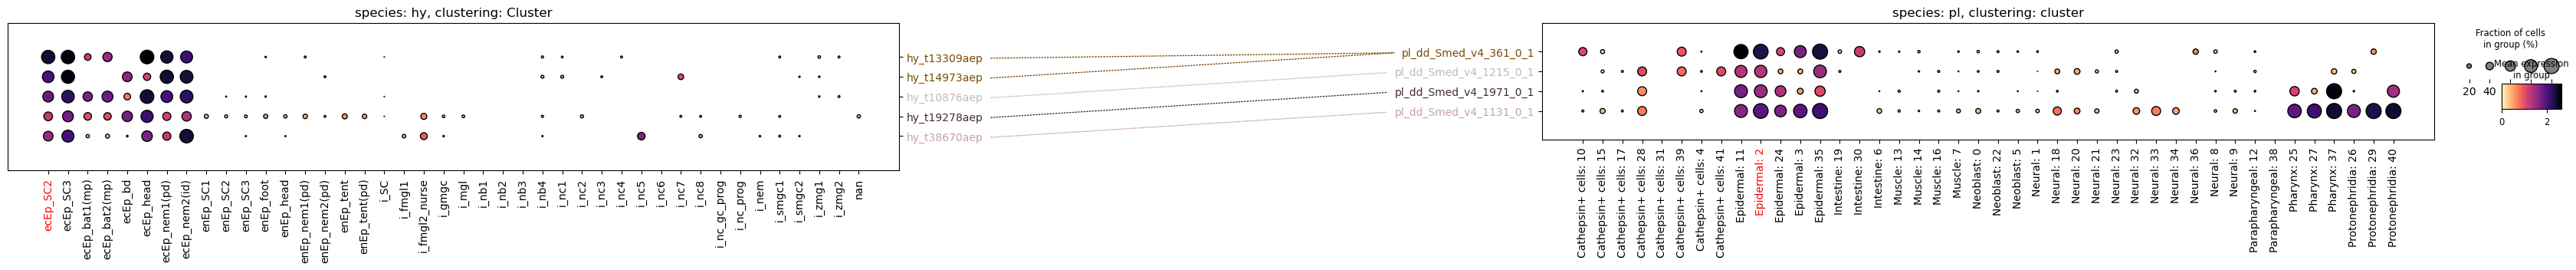

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_plain,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    pad=False,
)

Since we didn't supply any weights for the connections, the function uses a weight of 0, and plots all connections we provided as dotted lines. Let's try again, this time with weights:

<div class="alert alert-block alert-warning">
<details>
<summary>
<b>WARNING - Gene name padding:</b>
</summary>

We used `pad=False` here because we used the gene IDs instead of gene symbols. Gene symbols tend to
have the same length, and so `pad` doesn't help here. In fact `pad=True` will throw an issue here,
indicating possibly sloppy code. Unfortunately fixing this is not a priority.

</details>
</div>

In [ ]:
pd.DataFrame(connections_orth)

,0,1,2
0,hy_t13309aep,pl_dd_Smed_v4_361_0_1,0
1,hy_t14973aep,pl_dd_Smed_v4_361_0_1,0
2,hy_t10876aep,pl_dd_Smed_v4_1215_0_1,1
3,hy_t38670aep,pl_dd_Smed_v4_1131_0_1,2
4,hy_t19278aep,pl_dd_Smed_v4_1971_0_1,2


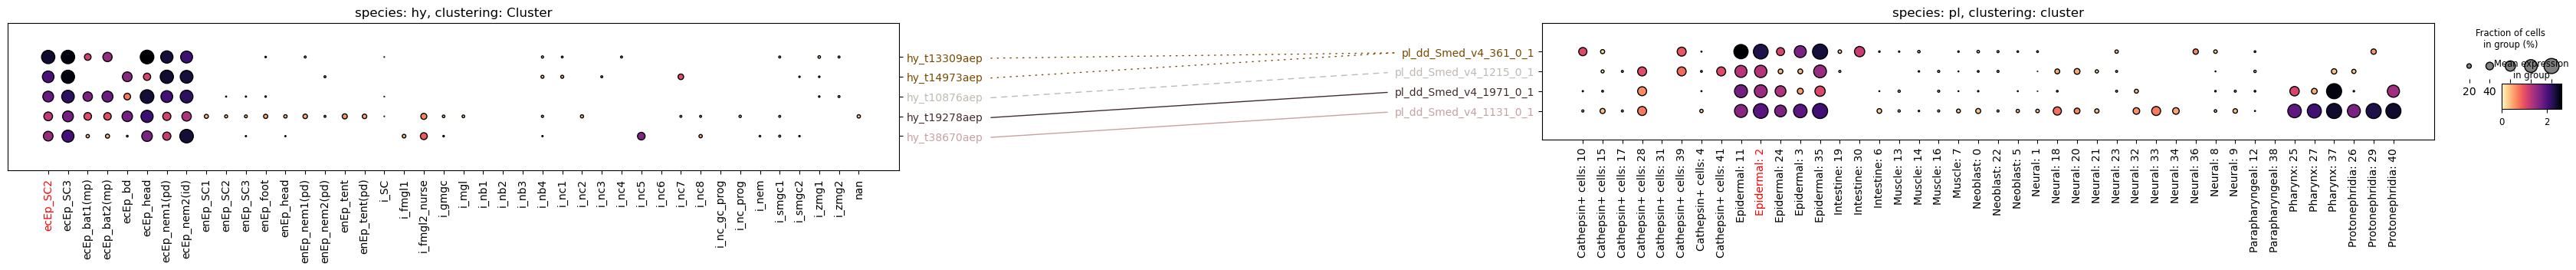

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    pad=False,
)

With weighting we can add an additional layer of information to the plot, such as orthology.

The next level would be to include the gene names, making this plot _actually_ useful. For this to
work reliably you need to have a column in the `.var` slot of your `AnnData` object that contains
_unique_ gene names. This is easily achieved by prepending the gene ID to the gene name/description.

I will demonstrate how I usually do this with EggNOG-mapper annotations; feel free to use whatever
works for you.

In [ ]:
query = pd.read_csv(
    os.environ["EXAMPLE_DATA_PATH"] + "eggnog/hydra.tsv", sep="\t", engine="python"
)

query = query[["Unnamed: 0", "5", "eggNOG_OGs", "21"]].copy()
query.columns = ["gene_id", "gene_name", "eggNOG_OGs", "description"]
query["gene_id"] = "hy_" + query["gene_id"].astype(str)
query.set_index("gene_id", inplace=True)
query["name"] = (
    query.index.astype(str)
    + " | "
    + query["gene_name"].fillna("")
    + " | "
    + query["description"].fillna("")
)

hydra.var["name"] = hydra.var.index
hydra.var["name"].replace(query["name"].to_dict(), inplace=True)

hy_t33417aep = "hy_t33417aep | EPT1 | diacylglycerol cholinephosphotransferase activity"
assert hydra.var.loc["hy_t33417aep"]["name"] == hy_t33417aep

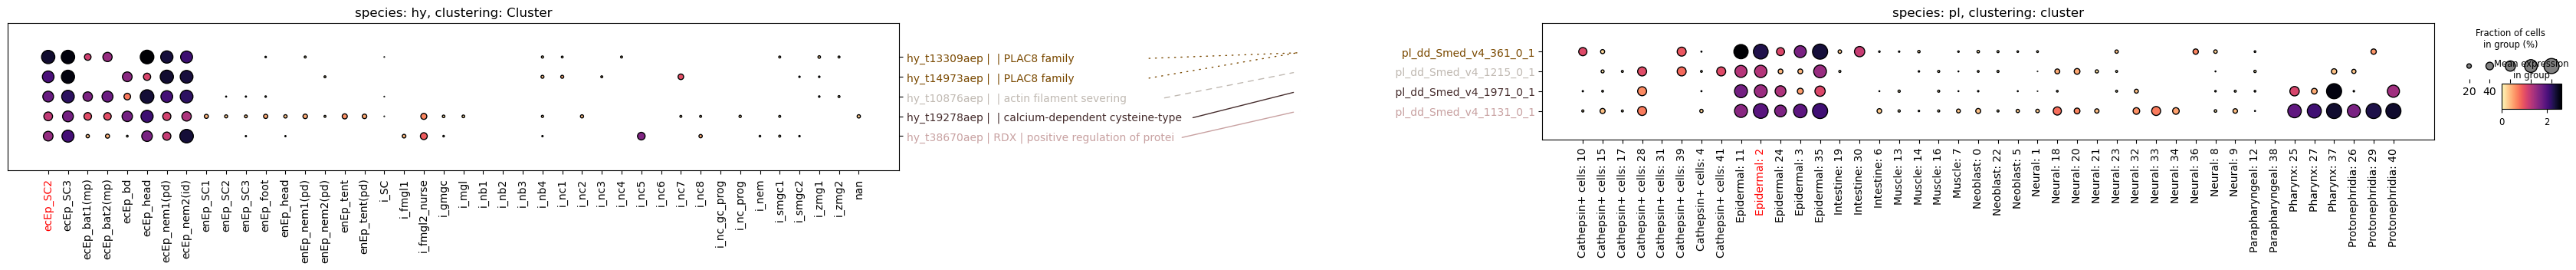

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    query_gene_names="name",
)

The right side of the plot is left as an exercise to the reader :) Notice how the lines on the left
side are not starting from the same spot. This is where the `util.procrustes` function tries to
guess how to pad using space characters so that the plotted strings have approximately the same
length and the lines don't go over some longer gene names. It's not perfect, but it's better than
nothing.

The other options of the function should be self-explanatory, but I'll go over them anyway:

- `x_offset` and `y_offset` control the canvas size beyond the size absolutely necessary for the
  plots to be rendered correctly. Increase `x_offset` to give the plots more x-axis space, and
  `y_offset` to give them more space on the vertical side. This is not an exact science, and you
  will find combinations that distort the plot to the point of making it unreadable.

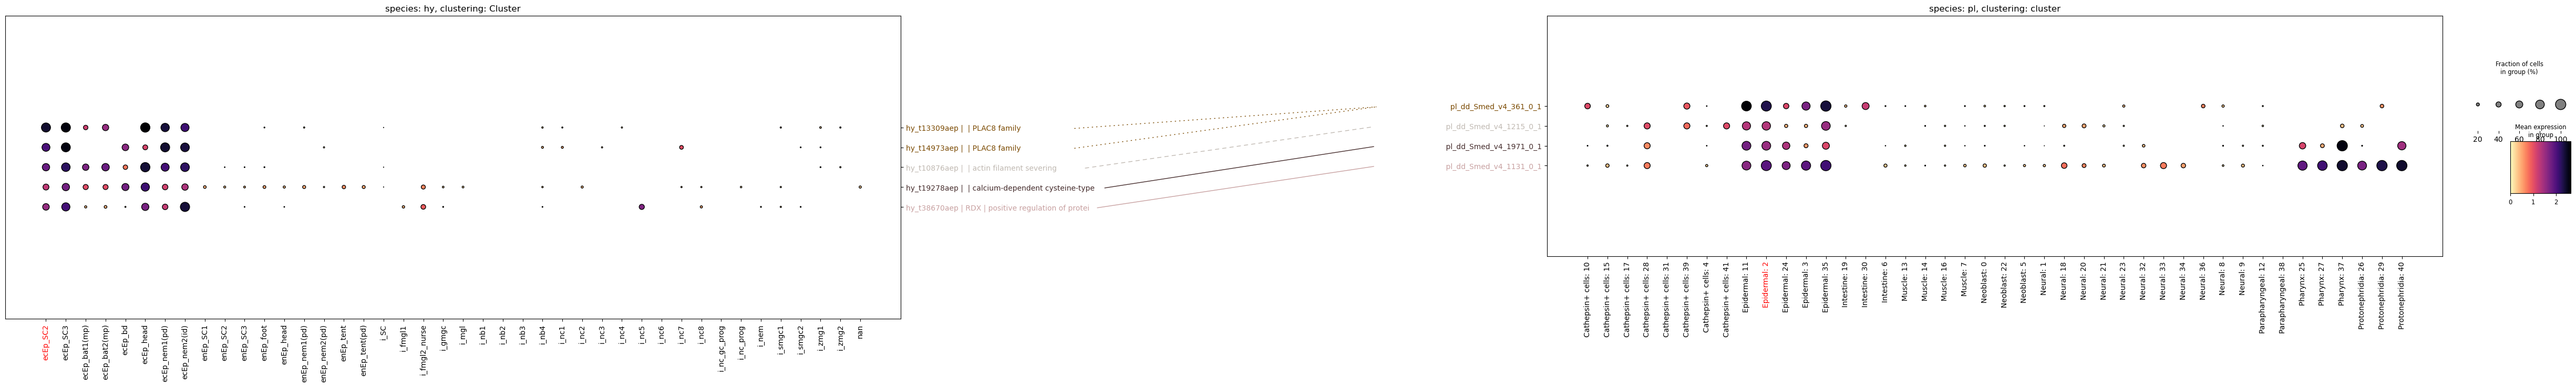

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    query_gene_names="name",
    x_offset=21,
    y_offset=5,
)

The `grid_offset` parameter tries to control the space between the dotplots. Play with it if the
lines connecting the genes are too short or too long. Try to stick to odd numbers, for some reason
they work better. This gives you an additional lever for when increasing `x_offset` doesn't work as
intended.

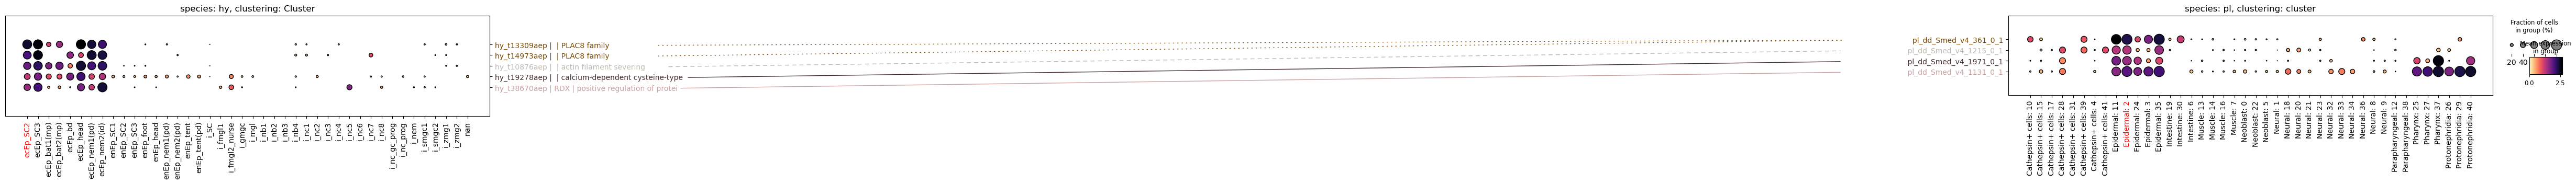

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    query_gene_names="name",
    grid_offset=131,
    x_offset=21,
)

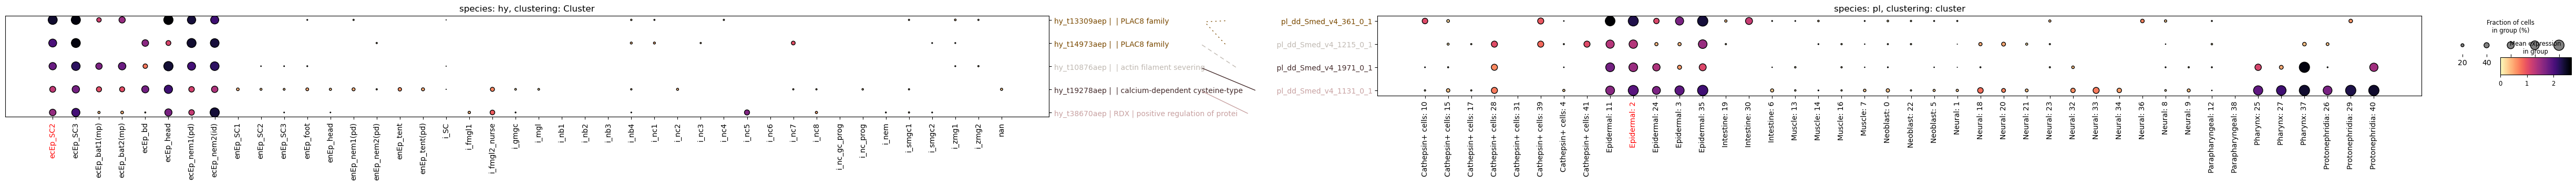

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    query_gene_names="name",
    grid_offset=13,
    x_offset=21,
)

The parameters `title` and `title_font_size` do what you expect them to do.

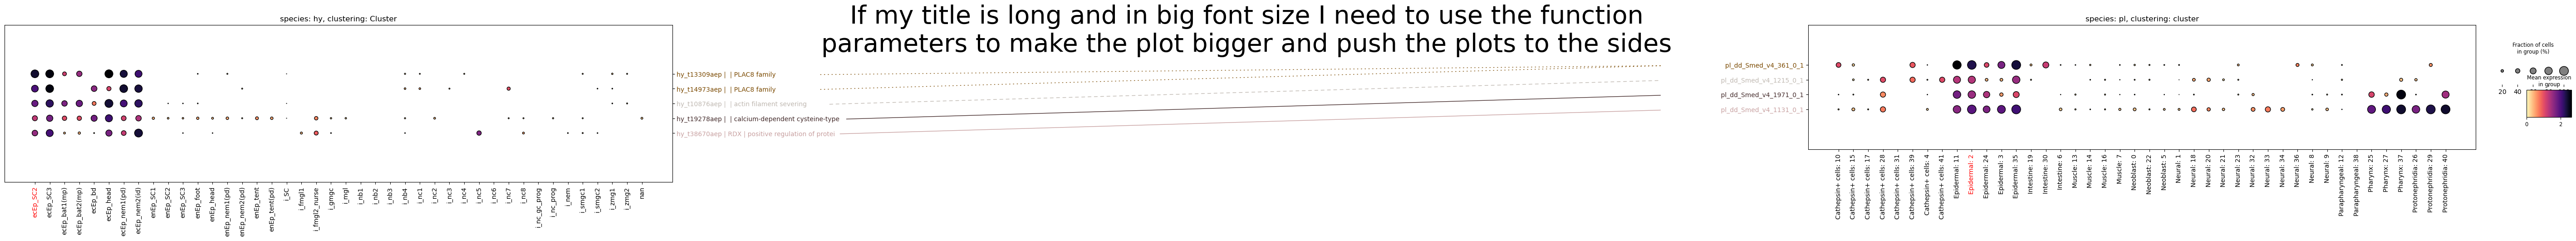

In [ ]:
paired_dotplot(
    query=hydra,
    target=planarian,
    connections=connections_orth,
    query_clustering="Cluster",
    target_clustering="cluster",
    query_species="hy",
    target_species="pl",
    query_cluster=cluster_from,
    target_cluster=cluster_to,
    query_gene_names="name",
    x_offset=31,
    y_offset=2,
    title="If my title is long and in big font size I need to use the function\nparameters to make the plot bigger and push the plots to the sides",
    title_font_size=40,
    grid_offset=71,
)

Finally, `output` controls where the plot is saved, and `center=True` will try to arrange the
dotplots so that their centers on the y-axis are aligned. You probably want `center=False` if you
need to print a title.

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()